# On Analyzing Real World Time Series for Forecasting: Bitcoin Price Dataset (2017-2023)

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

# from collections import namedtuple
from data_loader import build_bitcoin_uts

from ts_models import RandomWalk, AR, ARMA, ARIMA_model, EvaluationMetric
# from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Differenced Data
10. Plot Autocorrelation and Partial Autocorrelation of Differenced Data
11. Initialize & Predict Random Walk `RW` Model on Raw Data
    1. Split Differenced Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
reversed_bitcoin_ts = build_bitcoin_uts()

In [3]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


In [4]:
bitcoin_ts = reversed_bitcoin_ts.data_augment_reverse()
bitcoin_ts

UnivariateTimeSeries(close)

In [5]:
bitcoin_df = bitcoin_ts.get_as_df()
bitcoin_df

,close
Timestamp,
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


### Plot Raw Data

- August 2017 to July 2023. The data has been meticulously collected from the Binance API, with price data captured at **one-minute intervals** [About Dataset](https://www.kaggle.com/datasets/jkraak/bitcoin-price-dataset)

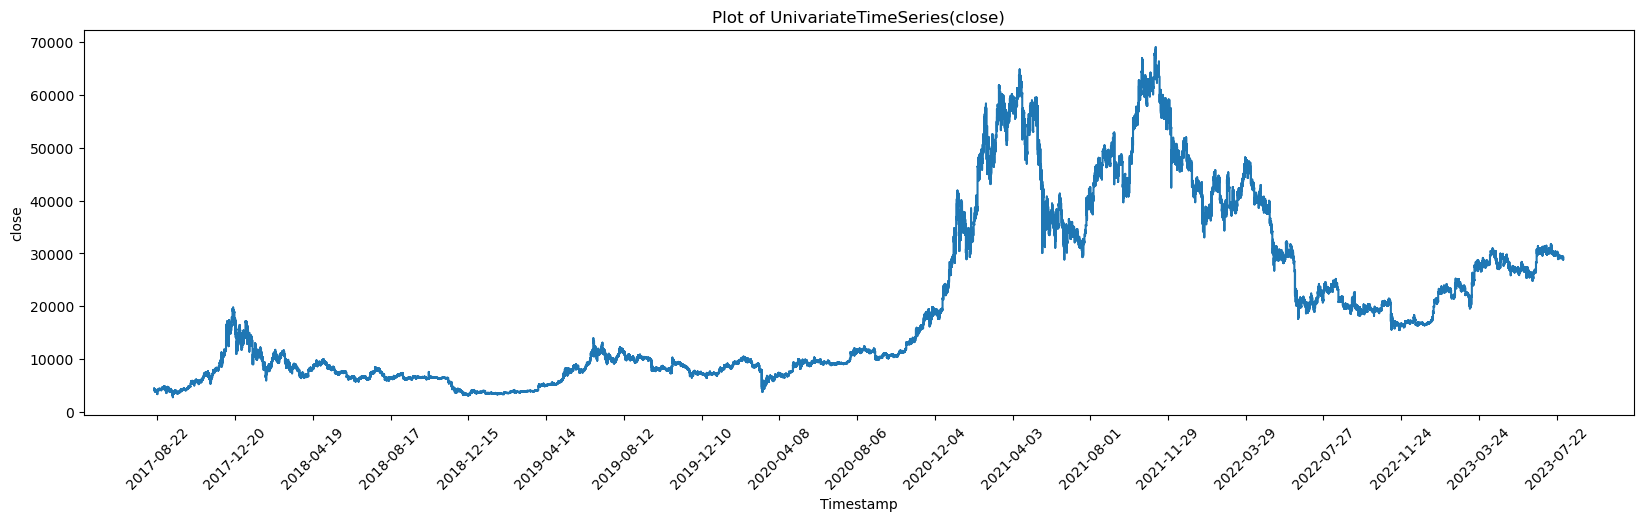

In [6]:
bitcoin_ts.plot(tick_skip=120)

### Get Descriptive Statistics of Raw Data

In [7]:
bitcoin_ts.get_statistics()

,close
count,3.126000e+06
mean,2.008946e+04
std,1.605896e+04
min,2.817000e+03
25%,7.624798e+03
50%,1.170000e+04
75%,2.989957e+04
max,6.900000e+04


In [8]:
bitcoin_ts.range_skewness_kurtosis()

{'Range': close    66183.0
 dtype: float64,
 'Skewness': close    1.029161
 dtype: float64,
 'Kurtosis': close   -0.056707
 dtype: float64}

### Check Stationarity of Raw Data

In [9]:
# both a taking a while
# bitcoin_ts.stationarity_test(bitcoin_df)

# from statsmodels.tsa.stattools import adfuller, bds

# adfuller(bitcoin_df)

- Stationarity test is taking a while. From looking at the graph, we can see that the time series is NOT stationary, so we can difference.

In [10]:
# bitcoin_series = bitcoin_ts.get_series()
# bitcoin_ts.independence_test(bitcoin_series)

- Independence test is taking a while as well. Assume that the data is dependent as there is correlation due to the time series being non-stationary.

### Difference

In [11]:
differenced_bitcoin_ts = bitcoin_ts.data_augment_with_differencing(1)
differenced_bitcoin_ts

UnivariateTimeSeries(Order-1 Difference of close)

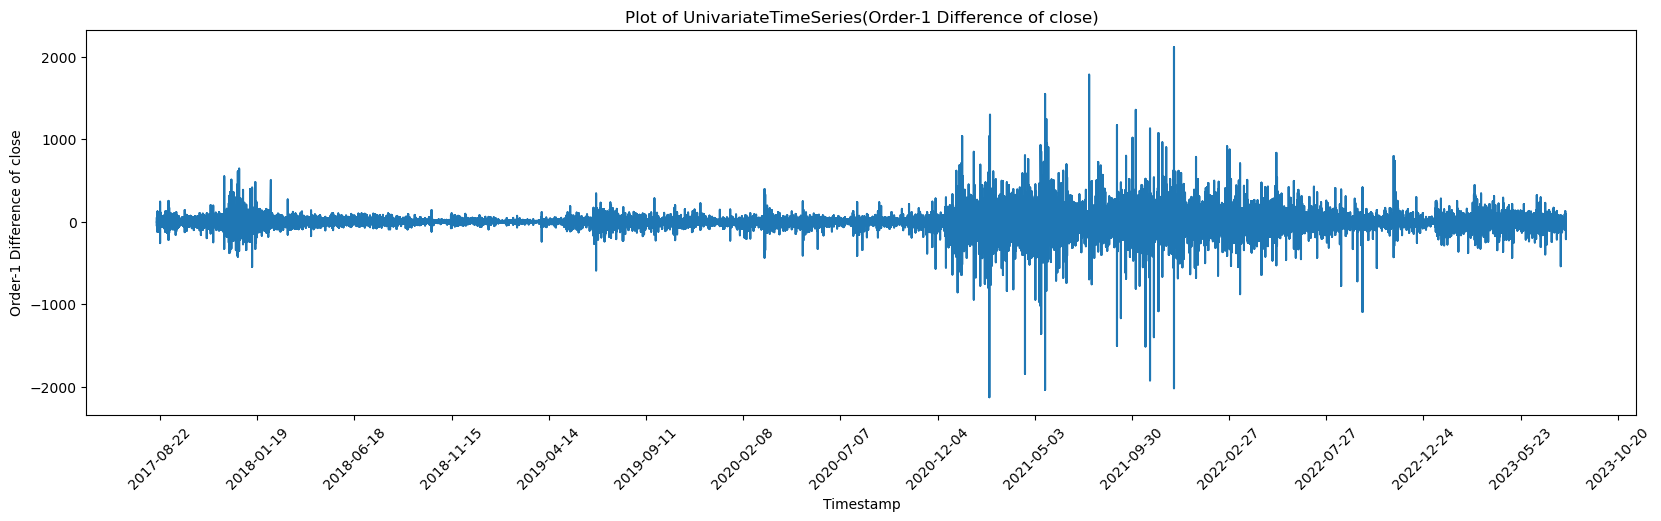

In [12]:
differenced_bitcoin_ts.plot(tick_skip=150)

- Data is differenced once. Will difference again to see plot and choose which is best as stationarity and independence test are taking a while on the raw data and assuming it'll take the same time on the differences as it's the same length. 

In [13]:
# differenced_2_bitcoin_ts = bitcoin_ts.data_augment_with_differencing(2)
# differenced_2_bitcoin_ts.plot(tick_skip=150)

- Too much differencing or code for 2nd diff and after is wrong? Will go with difference 1. 

### Get Descriptive Statistics of Differenced Data

In [14]:
differenced_bitcoin_ts.get_statistics()

,Order-1 Difference of close
count,3.125999e+06
mean,7.882603e-03
std,2.862586e+01
min,-2.129570e+03
25%,-5.180000e+00
50%,0.000000e+00
75%,5.160000e+00
max,2.115780e+03


In [15]:
differenced_bitcoin_ts.range_skewness_kurtosis()

{'Range': Order-1 Difference of close    4245.35
 dtype: float64,
 'Skewness': Order-1 Difference of close   -0.35713
 dtype: float64,
 'Kurtosis': Order-1 Difference of close    154.179352
 dtype: float64}

### Check Stationarity of Difference Data

In [16]:
# differenced_bitcoin_df = differenced_bitcoin_ts.get_as_df()
# differenced_bitcoin_ts.stationarity_test(differenced_bitcoin_df)

- Taking a while on the raw data and assuming it'll take the same time on the differenced data

### Plot Autocorrelation and Partial Autocorrelation of Difference Data

In [17]:
# differenced_bitcoin_ts.plot_autocorrelation(30)

- Exponentially dies out at lag 1, so no correlation between $ z_0 $  and $ z_1 $. With this, there doesn't exists any correlation between $ z_0 $ and the remaining $ z_{t - 1} $.
- Takes a while on entire dataset. Can run, have it print for first 30 or k lags, stop cell from running, and continue.

In [18]:
# differenced_bitcoin_ts.plot_partial_autocorrelation(35)

### Initialize AR(p) and ARMA(p, q) Models
- How to determine the proper lag p value? Look at the Partial ACor plot. Assumption: Being that we're out of the blue area at lag 1, we'll set our lag to be 1. Assuming because it takes a while to run PACor plot on entire dataset. 

- How to determine the proper error q value? Look at the ACor plot. Assumption: Being that we're out of the blue area at lag 1, we'll set our error to be 1. Assuming because it takes a while to run ACor plot on entire dataset. 

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Differences Data

#### Split Differenced Data
- Forecast for the entirety of the next day. Observations are currently in minutes, so would need 1440 as forecasting step (60 mins = 1 hr and 24 hrs in a day, so 60 * 24).
- Forecast for the entirety of the next year. (365 days = 1 hr and 24 hrs in a day, so 60 * 24 * 365)

In [19]:
diff_bitcoin_series = differenced_bitcoin_ts.get_series()
len(diff_bitcoin_series), diff_bitcoin_series

(3125999, array([  0.  ,  19.08, -19.08, ...,  -6.04,   0.  ,   0.  ]))

In [20]:
day_forecast = 60 * 24
year_forecast = day_forecast * 365
forecasting_step = year_forecast
diff_N = len(diff_bitcoin_series)
diff_train_length = diff_N - forecasting_step
diff_train_length

2600399

In [21]:
diff_train_uts, diff_test_uts = differenced_bitcoin_ts.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

1 2600399


(UnivariateTimeSeries(UnivariateTimeSeries(Order-1 Difference of close)[1:2600399]),
 UnivariateTimeSeries(UnivariateTimeSeries(Order-1 Difference of close)[2600399:3125999]))

In [22]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

,UnivariateTimeSeries(Order-1 Difference of close)[1:2600399]
Timestamp,
2017-08-17,19.08
2017-08-17,-19.08
2017-08-17,0.00
2017-08-17,0.00
2017-08-17,0.00
...,...
2022-08-01,7.67
2022-08-01,5.47
2022-08-01,9.82


In [23]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

,UnivariateTimeSeries(Order-1 Difference of close)[2600399:3125999]
Timestamp,
2022-08-01,-2.12
2022-08-01,-26.93
2022-08-01,21.22
2022-08-01,-49.23
2022-08-01,-13.02
...,...
2023-08-01,11.42
2023-08-01,1.12
2023-08-01,-6.04


In [24]:
lag_p = 1
# ar_model_class = AR()
# ar_model = ar_model_class.train_ar_model(diff_train_df, lag_p)

error_q = 1
arma_model_class = ARMA()
arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)

# integrated_d = 1 
# arima_model_class = ARIMA_model()
# arima_model = arima_model_class.train_arima_model(diff_train_df, lag_p, integrated_d, error_q)


/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
lag_p = 1
# ar_model_class = AR()
# ar_model = ar_model_class.train_ar_model(diff_train_df, lag_p)

error_q = 1
arma_model_class = ARMA()
arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)

integrated_d = 1 
arima_model_class = ARIMA_model()
arima_model = arima_model_class.train_arima_model(diff_train_df, lag_p, integrated_d, error_q)


/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date in

In [26]:
# retrain false
# ar_predictions_no_retrain = ar_model_class.predict(ar_model, diff_train_df, diff_test_df, False, lag_p)

# # retrain true
# ar_predictions_retrain = ar_model_class.predict(ar_model, diff_train_df, diff_test_df, True, lag_p)

# retrain false
arma_predictions_no_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, False, lag_p)

# retrain true
arma_predictions_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, True, lag_p)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
arma_predictions_no_retrain

2600398     2.240027e-01
2600399    -1.122875e-01
2600400     5.628722e-02
2600401    -2.821552e-02
2600402     1.414381e-02
               ...      
3125993   -4.940656e-324
3125994    4.940656e-324
3125995   -4.940656e-324
3125996    4.940656e-324
3125997   -4.940656e-324
Name: predicted_mean, Length: 525600, dtype: float64

In [28]:
arma_predictions_retrain

[array([3.01004039]),
 array([-1.59598262]),
 array([-14.4071296]),
 array([10.45610002]),
 array([-25.92218714]),
 array([-7.22441882]),
 array([14.08618318]),
 array([-17.37109508]),
 array([-2.88174465]),
 array([3.39215441]),
 array([8.92764395]),
 array([-8.47403493]),
 array([3.97048914]),
 array([4.85864604]),
 array([11.11705399]),
 array([1.9669724]),
 array([4.89995566]),
 array([1.2698725]),
 array([8.50938401]),
 array([7.55926267]),
 array([-8.29846903]),
 array([-12.67728912]),
 array([5.27690598]),
 array([1.00135995]),
 array([-11.71684037]),
 array([-6.90426924]),
 array([7.41467899]),
 array([-0.04170804]),
 array([10.70912146]),
 array([3.10298704]),
 array([17.24120567]),
 array([-4.64256735]),
 array([-10.26067614]),
 array([3.57288401]),
 array([-0.02105323]),
 array([8.26668998]),
 array([2.87578412]),
 array([11.39589395]),
 array([-0.37734873]),
 array([-10.82351976]),
 array([-8.29846903]),
 array([0.84644886]),
 array([-4.82846066]),
 array([2.36457753]),
 ar

In [29]:
# len(diff_test_df), len(ar_predictions_no_retrain), len(ar_predictions_retrain)
len(diff_test_df), len(arma_predictions_no_retrain), len(arma_predictions_retrain)

(525600, 525600, 525600)

In [30]:
# ar_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, ar_predictions_no_retrain, per_element=False)
# ar_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_no_retrain, per_element=False)

# ar_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, ar_predictions_retrain, per_element=False)
# ar_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_retrain, per_element=False)

arma_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
arma_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)

arma_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
arma_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

Test MSE: 234.540
Test RMSE: 15.315
Test MSE: 296.645
Test RMSE: 17.223


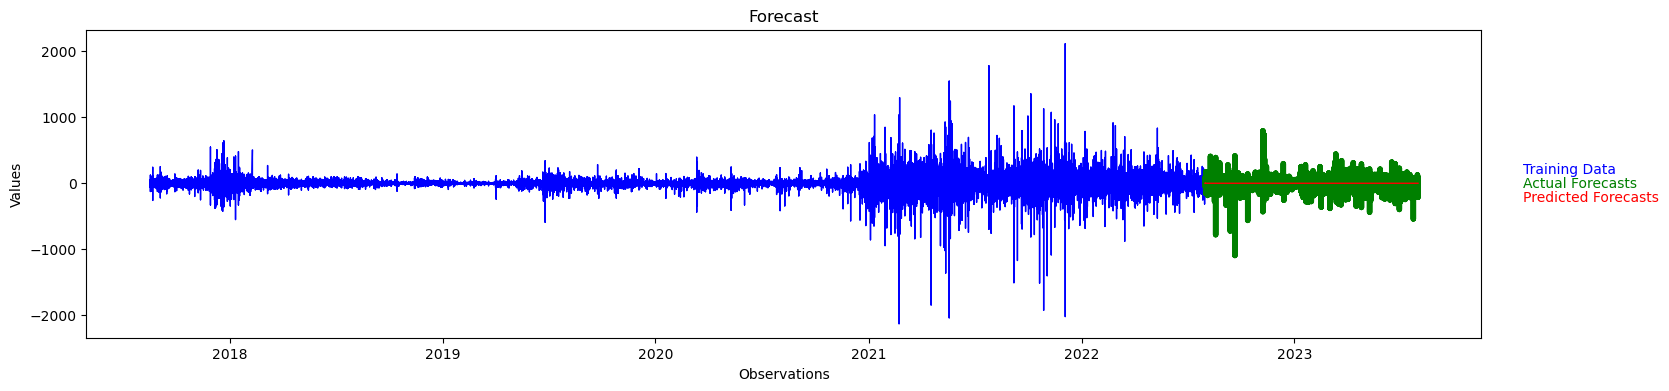

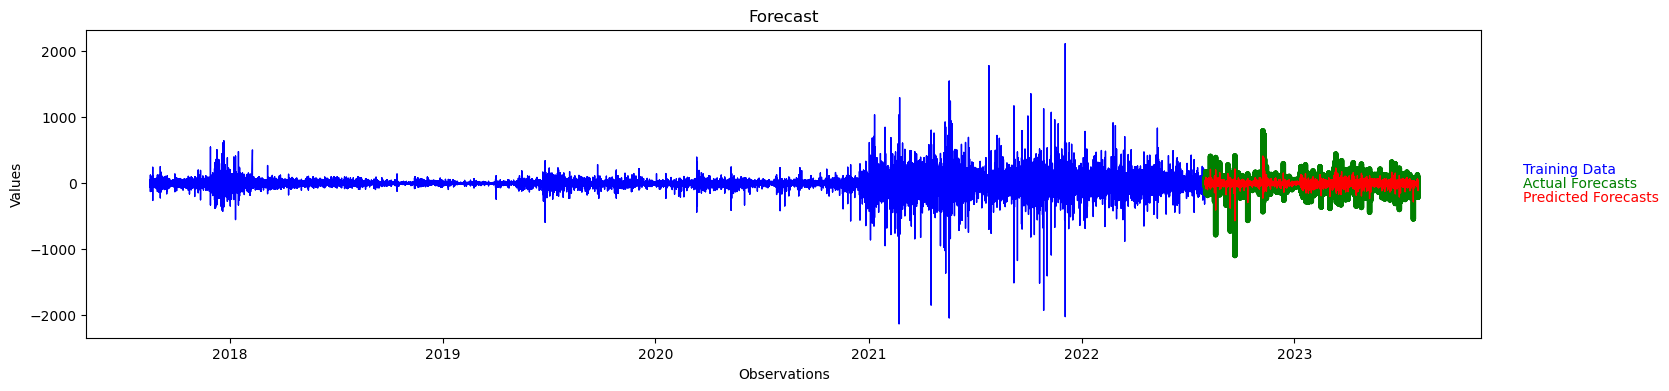

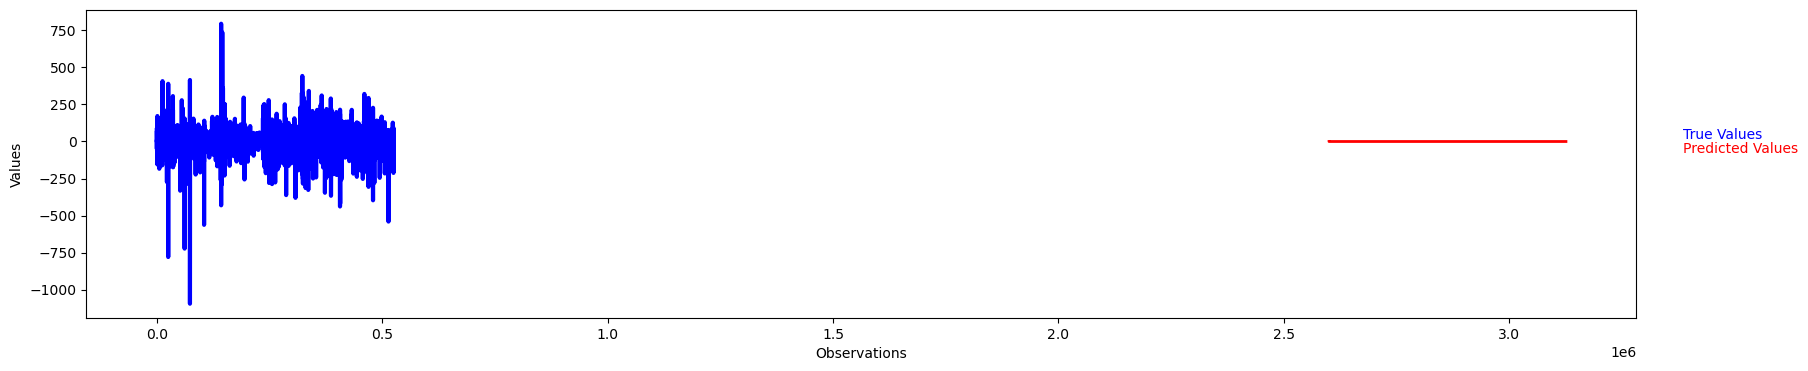

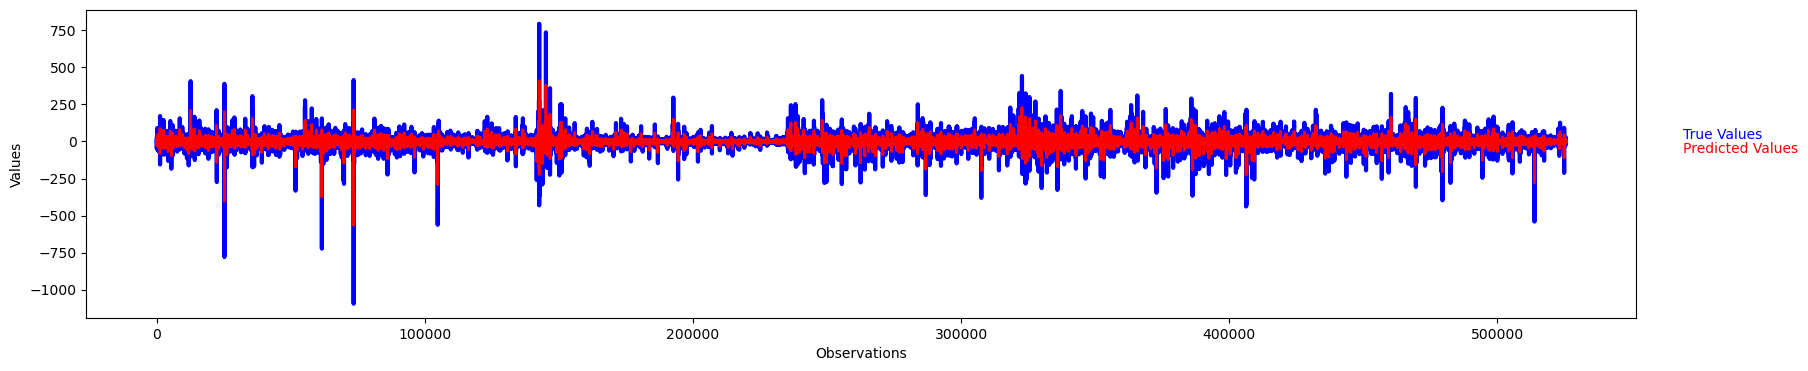

In [31]:
# EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, ar_predictions_no_retrain, False)
# EvaluationMetric.plot_predictions(diff_test_df, ar_predictions_no_retrain)
# EvaluationMetric.plot_predictions(diff_test_df, ar_predictions_retrain)


EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_no_retrain, False)
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_retrain, False)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_no_retrain)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_retrain)

### ARIMA

In [32]:
integrated_d = 1 
arima_model_class = ARIMA_model()
arima_model = arima_model_class.train_arima_model(diff_train_df, lag_p, integrated_d, error_q)


/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
# retrain false
arima_predictions_no_retrain = arima_model_class.predict(arima_model, diff_train_df, diff_test_df, False, lag_p)

# retrain true
arima_predictions_retrain = arima_model_class.predict(arima_model, diff_train_df, diff_test_df, True, lag_p)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [34]:
arima_predictions_no_retrain

2600398    0.097715
2600399    0.023759
2600400    0.022943
2600401    0.022934
2600402    0.022933
             ...   
3125993    0.022933
3125994    0.022933
3125995    0.022933
3125996    0.022933
3125997    0.022933
Name: predicted_mean, Length: 525600, dtype: float64

In [35]:
arima_predictions_retrain

[array([-6.78831182]),
 array([2.13083066]),
 array([26.93844558]),
 array([-21.20692557]),
 array([49.23630179]),
 array([13.0297828]),
 array([-28.23624975]),
 array([32.67789377]),
 array([4.62059129]),
 array([-7.52824068]),
 array([-18.24721013]),
 array([15.44955016]),
 array([-8.64813301]),
 array([-10.36796766]),
 array([-22.48680252]),
 array([-4.76850601]),
 array([-10.44795997]),
 array([-3.41863579]),
 array([-17.437288]),
 array([-15.59746488]),
 array([15.10958284]),
 array([23.58876763]),
 array([-11.17788979]),
 array([-2.89868578]),
 array([21.72894644]),
 array([12.4098424]),
 array([-15.3174918]),
 array([-0.87887997]),
 array([-21.69687847]),
 array([-6.96829452]),
 array([-34.34566237]),
 array([8.03026347]),
 array([18.90921753]),
 array([-7.87820704]),
 array([-0.91887613]),
 array([-16.96733318]),
 array([-6.52833682]),
 array([-23.02675061]),
 array([-0.22894246]),
 array([19.99911275]),
 array([15.10958284]),
 array([-2.59871462]),
 array([8.39022886]),
 array

In [36]:
# len(diff_test_df), len(ar_predictions_no_retrain), len(ar_predictions_retrain)
len(diff_test_df), len(arima_predictions_no_retrain), len(arima_predictions_retrain)

(525600, 525600, 525600)

In [37]:
arima_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, arima_predictions_no_retrain, per_element=False)
arima_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, arima_predictions_no_retrain, per_element=False)

arima_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, arima_predictions_retrain, per_element=False)
arima_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, arima_predictions_retrain, per_element=False)

Test MSE: 234.540
Test RMSE: 15.315
Test MSE: 470.369
Test RMSE: 21.688


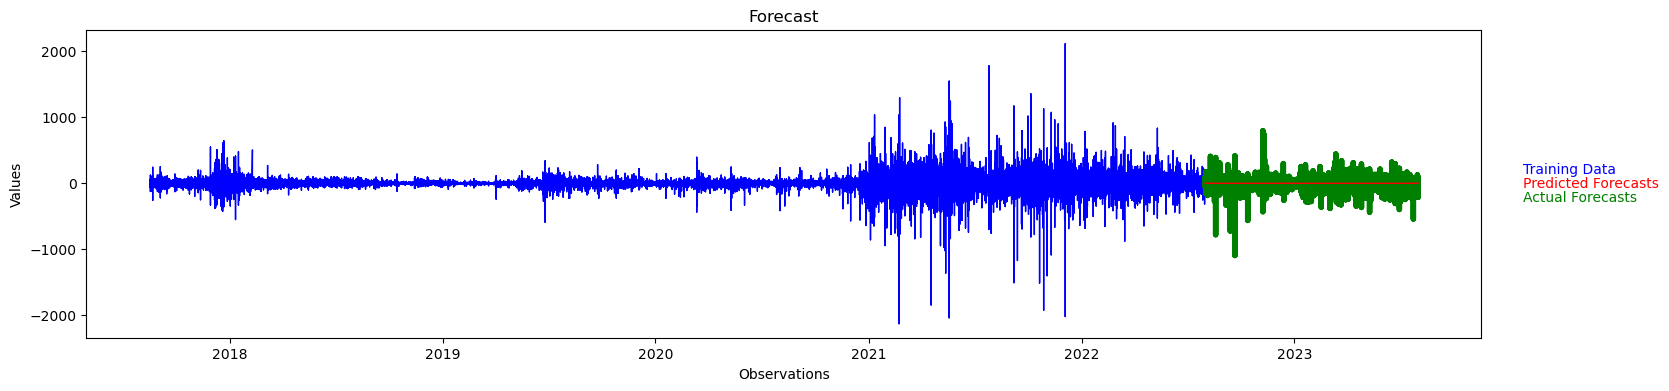

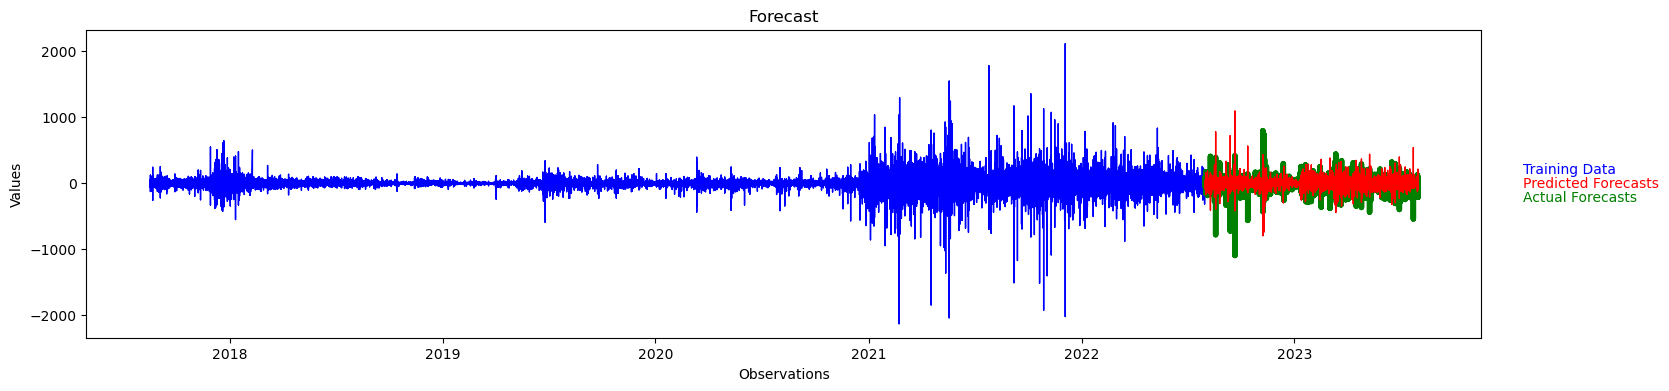

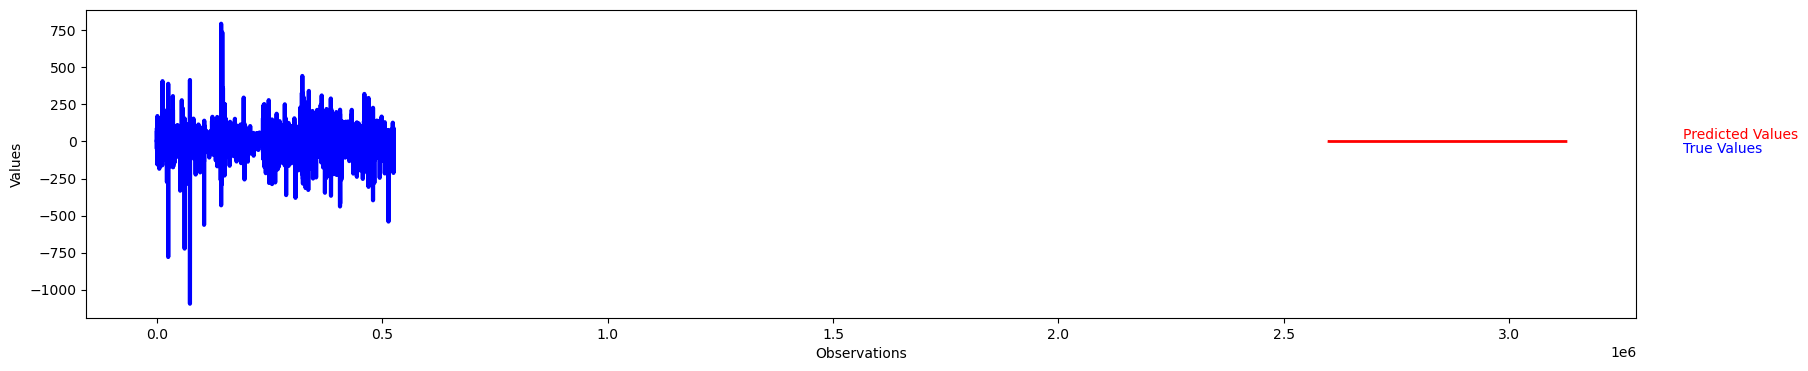

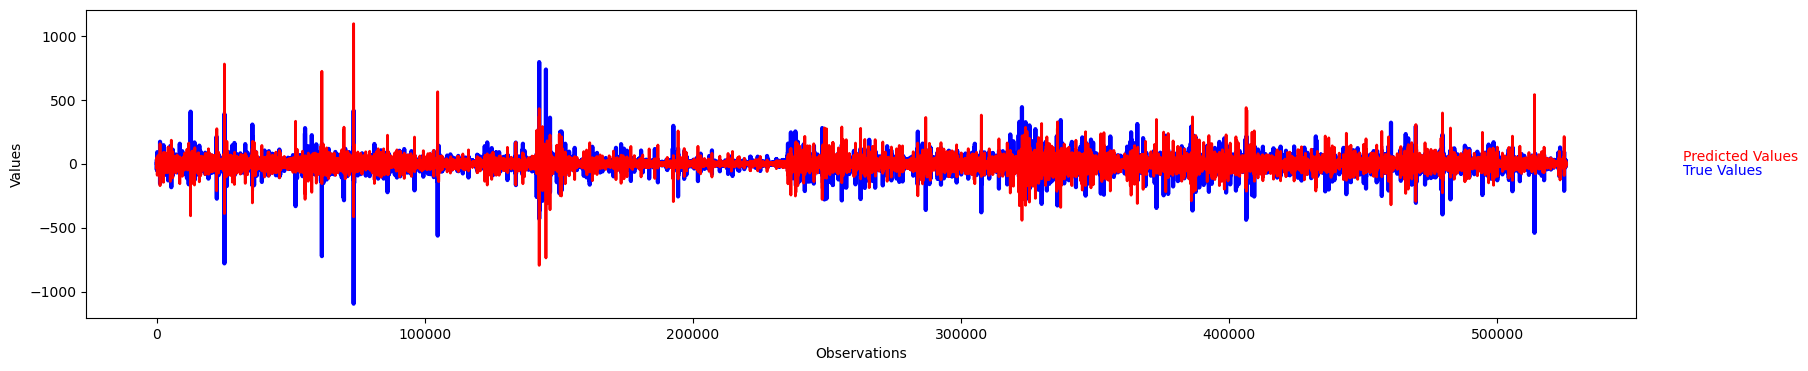

In [38]:
# EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, ar_predictions_no_retrain, False)
# EvaluationMetric.plot_predictions(diff_test_df, ar_predictions_no_retrain)
# EvaluationMetric.plot_predictions(diff_test_df, ar_predictions_retrain)


EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arima_predictions_no_retrain, False)
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arima_predictions_retrain, False)
EvaluationMetric.plot_predictions(diff_test_df, arima_predictions_no_retrain)
EvaluationMetric.plot_predictions(diff_test_df, arima_predictions_retrain)

### Follow-up
- What can we determine from this?
    - Differenced TS
        - `ARMA-no-retrain`
        - `ARMA-retrain`
        - `ARIMA-no-retrain`
        - `ARIMA-retrain` 